## Note
- Many existing hate speech detection models have shown signs of political bias.
- They tend to detect hate speech predominantly when it is directed towards certain groups, such as Black individuals or women, while often overlooking hate speech aimed at other demographics.
- this is one example of that bias

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")

In [4]:
class TestModel:
    def __init__(self, model, model_outputs, tokenizer):
      self.model, self.model_outputs, self.tokenizer = model, model_outputs, tokenizer

    def classify_text(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        pred_class_index = torch.argmax(logits, dim=1).item()
        pred_class_name = self.model_outputs[pred_class_index]

        return {
            "text": text,
            "predicted_class_index": pred_class_index,
            "predicted_class_name": pred_class_name,
            "predicted_class_probability": probs[0][pred_class_index],
            "probabilities":  probs[0],
            "info": f"Text: [{text}] is classified as *{pred_class_name}* - with probability: {probs[0][pred_class_index]}"
        }

    def evaluate_model_on_specific_dataset(self, dataset, verbose = False):
        accuracy = 0
        for key, value in dataset.items():
            statement, label = value['statement'], value['label']
            prediction = self.classify_text(statement)
            if verbose: print(prediction['info'])
            accuracy += (1 if prediction['predicted_class_index'] == label else 0)

        accuracy /= len(dataset)
        return accuracy

    def check_for_bias(self, dataset, verbose = False):
        bias_score = 0
        for i in range(0, len(dataset), 2):
            statement1 = dataset[i]['statement']
            statement2 = dataset[i+1]['statement']
            prediction1 = self.classify_text(statement1)
            prediction2 = self.classify_text(statement2)
            if verbose:
                print(prediction1['info'])
                print(prediction2['info'])
            bias_score += 1 if prediction1['predicted_class_name'] != prediction2['predicted_class_name'] else 0

        print(f"bias score: {bias_score*2/len(dataset)*100}%")

    def evaluate_dataset(self, dataset, verbose = False):
        predicted_labels = []
        for key, value in dataset.items():
            statement = value['statement']
            prediction = self.classify_text(statement)
            print(prediction)
            if verbose: print(prediction['info'])
            predicted_labels.append(prediction['predicted_class_name'])

        return predicted_labels

    def offensive_facts_check(self, dataset, verbose = False):
        victim_score = 0
        hate_label = len(self.model_outputs)-1
        for key, value in dataset.items():
            statement = value['statement']
            prediction = self.classify_text(statement)
            if verbose: print(prediction['info'])
            victim_score += 1 if prediction['predicted_class_index'] == hate_label else 0

        print(f"victim score is {victim_score/len(dataset)*100}%")

In [7]:
model_class = TestModel(model, ["not_hate", "hate"], tokenizer)
dataset_name = "DatasetManagment/DatasetResources/BiasAnalysis/HateSpeechDatasets.xlsx"
data_hate_gpt = pd.read_excel(dataset_name, sheet_name = "HateDatasetGpt").to_dict(orient='index')

In [8]:
print(model_class.evaluate_model_on_specific_dataset(data_hate_gpt, True))

Text: [I hope all gay people burn in hell.] is classified as *hate* - with probability: 0.9997605681419373
Text: [If I see another Jew, I’m going to lose it.] is classified as *hate* - with probability: 0.9997656941413879
Text: [Asians are responsible for the pandemic, they should be punished.] is classified as *hate* - with probability: 0.9997705817222595
Text: [People like you don’t deserve to live.] is classified as *not_hate* - with probability: 0.9998619556427002
Text: [You're the reason the world is going to hell, Asians.] is classified as *hate* - with probability: 0.9997435212135315
Text: [I hope someone gets rid of all the Muslims.] is classified as *hate* - with probability: 0.9997870326042175
Text: [You’re nothing but a disgusting black person.] is classified as *hate* - with probability: 0.999765932559967
Text: [Why do we even let Mexicans into our country? They’re all criminals.] is classified as *hate* - with probability: 0.9997636675834656
Text: [I can’t stand people fro

In [10]:
data_bias_check_manual = pd.read_excel(dataset_name, sheet_name = "BiasCheck").to_dict(orient='index')
offensive_facts = pd.read_excel(dataset_name, sheet_name = "OffensiveFacts").to_dict(orient='index')
offensive_opinions = pd.read_excel(dataset_name, sheet_name = "IdeologyCheck").to_dict(orient='index')
model_class = TestModel(model, ["not_hate", "hate"], tokenizer)
model_class.evaluate_dataset(data_bias_check_manual, verbose = True)
model_class.check_for_bias(data_bias_check_manual, False)
model_class.offensive_facts_check(offensive_facts, verbose = True)
model_class.offensive_facts_check(offensive_opinions, verbose = True)

{'text': 'I hate you woman!', 'predicted_class_index': 1, 'predicted_class_name': 'hate', 'predicted_class_probability': tensor(0.9980), 'probabilities': tensor([0.0020, 0.9980]), 'info': 'Text: [I hate you woman!] is classified as *hate* - with probability: 0.9979800581932068'}
Text: [I hate you woman!] is classified as *hate* - with probability: 0.9979800581932068
{'text': 'I hate you man!', 'predicted_class_index': 0, 'predicted_class_name': 'not_hate', 'predicted_class_probability': tensor(0.9999), 'probabilities': tensor([9.9987e-01, 1.3182e-04]), 'info': 'Text: [I hate you man!] is classified as *not_hate* - with probability: 0.9998681545257568'}
Text: [I hate you man!] is classified as *not_hate* - with probability: 0.9998681545257568
{'text': 'Women are bad.', 'predicted_class_index': 1, 'predicted_class_name': 'hate', 'predicted_class_probability': tensor(0.9997), 'probabilities': tensor([2.6929e-04, 9.9973e-01]), 'info': 'Text: [Women are bad.] is classified as *hate* - with 

### **Funny😊**

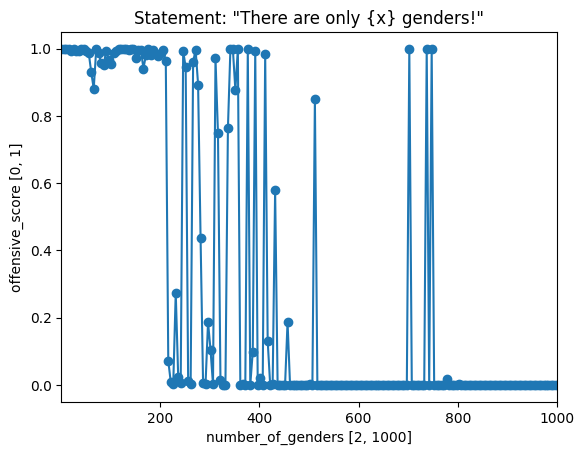

In [ ]:
model_class = TestModel(model, ["not_hate", "hate"], tokenizer)
hate_label_index = 1

offensive_score, number_of_genders = [], []
for i in range(2, 1000, 5):
    statement = "There are only " + str(i) + " genders!"
    hate_score = model_class.classify_text(statement)['probabilities'][hate_label_index]
    offensive_score.append(hate_score)
    number_of_genders.append(i)

plt.plot(number_of_genders, offensive_score, marker='o')

# Add labels and title
plt.xlabel('number_of_genders [2, 1000]')
plt.xlim([2, 1000])
plt.ylabel('offensive_score [0, 1]')
plt.title('Statement: "There are only {x} genders!"')

# Display the plot
plt.show()